# 처음변수만

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss


import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #colab용
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/')

In [4]:
path = "./data/"
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

In [5]:
train_df.shape, test_df.shape

((199991, 22), (10009, 21))

## DATA Setting

In [6]:
def del_outlier(data, min=0, max=60):
    up_idx_t=()
    dw_idx_t=()
    train_light = data.iloc[:,2:]
    for i in range(len(train_light.columns)):
        col = train_light.columns[i]
        up_idx_t+=tuple(data[data[col]>max].index)
        dw_idx_t+=tuple(data[data[col]<min].index)
    del_idx = set(up_idx_t+dw_idx_t)
    
    return data[~data.index.isin(del_idx)]

In [7]:
train_df = del_outlier(train_df, min=-30, max=30)

In [8]:
train_df.shape

(198767, 22)

In [9]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [10]:
def add_minus_feature(data,test = False):
    '''
    근접변수에 대해서만 컬럼생성 ex) 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z'
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 38개로 증가 
    '''
    from itertools import combinations
    n = 0
    m = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for i in range(0,len(selected)):        
            if i>0: 
                name_1st = str.split(m,'_')[1]
                name_2nd = str.split(selected[i],'_')[1]
                data[mag+"_"+name_1st+"-"+name_2nd] = data[m]-data[selected[i]]
            m = selected[i]    
        n=count
    return data

In [11]:
def add_minus_feature_all(data,test = False):
    '''
    combination으로 모든 변수들의 조합에 대해서 컬럼생성 
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 64개로 증가
    '''
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [13]:
train_df = add_minus_feature_all(train_df)
test_df = add_minus_feature_all(test_df,True)

In [14]:
train_X = train_df.drop(columns=['type', 'type_num'], axis=1)
train_y = train_df['type_num']
test_X = test_df

In [15]:
train_X.shape, test_X.shape

((198767, 61), (10009, 61))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

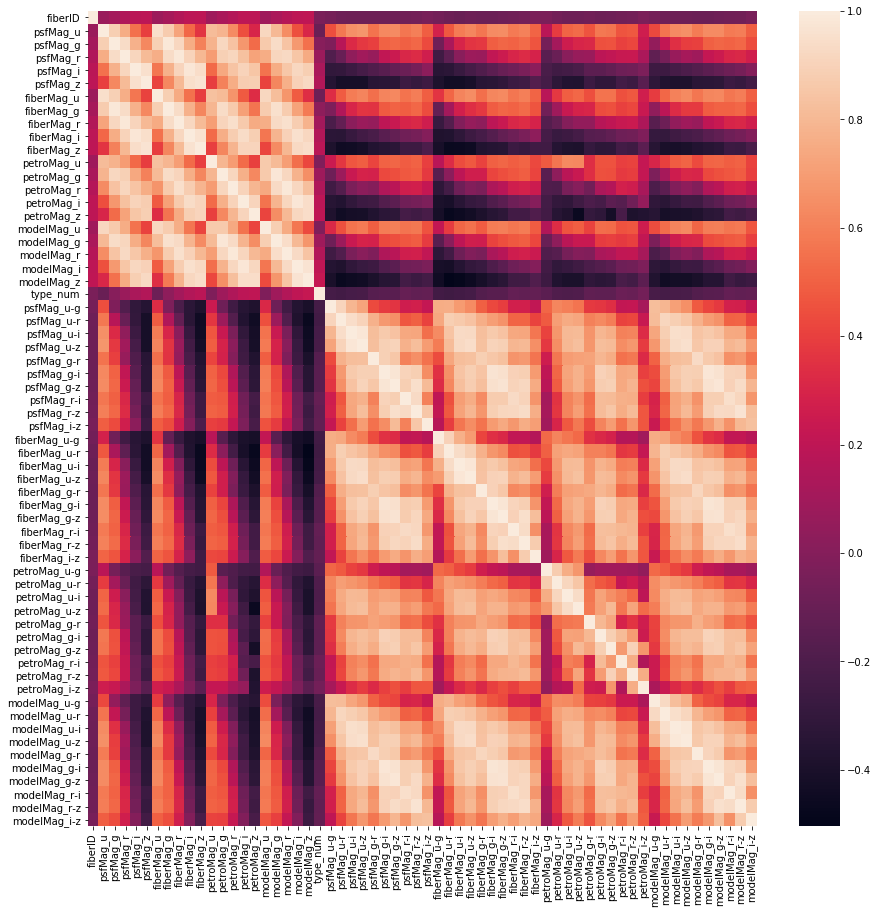

In [17]:
plt.figure(figsize =(15,15))
sns.heatmap(train_df.corr())

# FE

### corr

In [19]:
default_lgbm = lgb.LGBMClassifier()

In [20]:
def simlpe_lgbm(model, X, y, test_size=0.2):
    '''
    RFE용으로 logloss보존
    '''
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import log_loss
    
    #train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state = 42)
    model.fit(X,y)
    
    print("used col:", X.shape[1])
    print("train score:",model.score(X_train,y_train))
    print("test score:",model.score(X_test,y_test))
    
    pred_y = model.predict_proba(X_test)
    logloss = log_loss(y_test,pred_y,labels= list(set(y_test)))
    print('logloss:',logloss)
    
    #report and importance
    
    return logloss

In [21]:
def cor_selector(X, y, parcent = 0.9):
    '''
    correlation을 이용한
    X,y값을 전달하면 해당컬럼의 parcent만큼의 feature만 선택하여 feature만 반환
    (선택된 feature들의 상관관계를 확인하려면 return을 corr_df로 변경)
    '''
    n_features = round(len(X.columns) * parcent)
    cor_list = []
    # calculate the correlation with y for each feature
    # y와의 상관계수를 파악한다
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    # 0인게 있다면 NAN으로 대체한다(결측치 혹은 전부 동일한값의 경우)
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    # 상관계수에 절대값을 사용해 부호통일후 
    # argsort를 사용해 상관계수가 높은 n_fearture개를 선택한다
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-(n_features):]].columns.tolist()
    selected_corr = np.abs(cor_list)[(np.argsort(np.abs(cor_list)))[-(n_features):]]
    
    #선택된 feature와 corr 높은순서대로 보여줌
    corr_df = pd.DataFrame(index= cor_feature,data = selected_corr,columns=["corr"]).sort_values("corr",ascending=False)
   
    # feature selection? 0 for not select, 1 for select
    # 전체중에서 Ture인 변수들만 선택되었음 (False는 미선택된 경우)
    cor_support = [True if i in cor_feature else False for i in X.columns.values]
    
    print(str(len(cor_feature)), 'selected features')
    return cor_feature, cor_support

In [22]:
cor_feature, cor_support = cor_selector(train_X,train_y, 0.7)

43 selected features


In [24]:
fea = []
sup = []
cohens =[]
for p in [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]:
    cor_feature, cor_support = cor_selector(train_X, train_y, parcent = p )
    cohen = simlpe_lgbm(default_lgbm, train_X[cor_feature], train_y, test_size=0.2)
    fea.append(cor_feature)
    sup.append(cor_support)
    cohens.append(cohen)

55 selected features
used col: 55
train score: 0.8531566601472835
test score: 0.8547567540373295
logloss: 1.8746404264409684
49 selected features
used col: 49
train score: 0.8695767012759963
test score: 0.871836796297228
logloss: 0.9550390671767277
43 selected features
used col: 43
train score: 0.8798274354926956
test score: 0.8815213563415002
logloss: 0.6243651575485272
37 selected features
used col: 37
train score: 0.8611748724947017
test score: 0.8628565678925391
logloss: 1.2710676578690143
30 selected features
used col: 30
train score: 0.8730166715928886
test score: 0.8774211400110681
logloss: 0.6840662037618217
24 selected features
used col: 24
train score: 0.8598982473131128
test score: 0.8611963575992353
logloss: 1.0129112220097063
18 selected features
used col: 18
train score: 0.7983183764849415
test score: 0.7988630074961011
logloss: 2.863557918323048
12 selected features
used col: 12
train score: 0.8470691075572437
test score: 0.8492478744277305
logloss: 0.8218568607828501
6 

In [37]:
corr = fea[4]

In [38]:
corr

['psfMag_z',
 'modelMag_r',
 'psfMag_g-z',
 'modelMag_g-z',
 'modelMag_g-i',
 'fiberMag_g-z',
 'fiberMag_g-i',
 'psfMag_g-r',
 'fiberMag_g-r',
 'modelMag_g-r',
 'fiberMag_z',
 'petroMag_u-r',
 'petroMag_u-z',
 'petroMag_i',
 'petroMag_u-i',
 'modelMag_i',
 'petroMag_z',
 'modelMag_u-z',
 'modelMag_u-g',
 'modelMag_u-i',
 'psfMag_u-z',
 'modelMag_z',
 'psfMag_u-i',
 'psfMag_u-g',
 'modelMag_u-r',
 'fiberMag_u-z',
 'fiberMag_u-i',
 'psfMag_u-r',
 'fiberMag_u-g',
 'fiberMag_u-r']

### SELECT_FROM_MODEL

In [25]:
def SFML(model, X, y):
    '''
    SelectFromModel를 활용 threshold는 변경가능하지만 정확힌 잘 모르겠음
    '''
    from sklearn.feature_selection import SelectFromModel
    embeded_lgb_selector = SelectFromModel(default_lgbm, threshold='1.25*median')
    embeded_lgb_selector.fit(X, y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    
    return embeded_lgb_feature, embeded_lgb_support

In [26]:
embeded_lgb_feature,embeded_lgb_support = SFML(default_lgbm,train_X,train_y)

13 selected features


In [27]:
embeded_lgb_feature

['fiberID',
 'psfMag_g',
 'psfMag_r',
 'psfMag_i',
 'petroMag_u',
 'psfMag_u-g',
 'psfMag_g-r',
 'psfMag_r-i',
 'fiberMag_u-g',
 'petroMag_u-g',
 'petroMag_u-i',
 'petroMag_u-z',
 'modelMag_u-g']

### KBEST

In [42]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2

In [28]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2
def Kbest_iter(X,y, score_func= f_classif, select=7, iteration = 11):
    '''
    Kbest를 반복하여 추출
    추출방법은 f_classif, chi2가 분류에 적합
    '''
    
    n_selects = np.arange(select,select*iteration+1,select)
    
    feature_names_lst = []
    Kbest_support_lst = []
    scores_lst =[]
    for n in n_selects:
        selector = SelectKBest(score_func, k = n)
        X_new = selector.fit_transform(X, y)
        
        #추출대상
        names = X.columns.values[selector.get_support()]
        Kbest_support = selector.get_support()
        scores = selector.scores_[selector.get_support()]
        
        #순서대로 정렬하기 위함
        names_scores = list(zip(names, scores))
        ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
        ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
        
        #저장
        feature_names_lst.append(ns_df_sorted['Feat_names'].values)
        Kbest_support_lst.append(Kbest_support)
        scores_lst.append(ns_df_sorted['F_Scores'].values)
    
    #코헨의 카파 
    kbest_cohens=[]
    for selected_f in feature_names_lst:
        kbest_cohen = simlpe_lgbm(default_lgbm, X[selected_f], y, test_size=0.2)
        kbest_cohens.append(kbest_cohen)

    return kbest_cohens,feature_names_lst,Kbest_support_lst, scores_lst
        
    

In [32]:
kbest_cohens,feature_names_lst,Kbest_support_lst, scores_lst = Kbest_iter(train_X,train_y, score_func= f_classif, select=6, iteration = 10)

used col: 6
train score: 0.7121052995667021
test score: 0.7142929013432611
logloss: 1.1147923640017758
used col: 12
train score: 0.7345814493154648
test score: 0.7370327514212406
logloss: 1.4860680425830761
used col: 18
train score: 0.8623005666203393
test score: 0.8646928610957388
logloss: 0.8623967762383097
used col: 24
train score: 0.8679227484545289
test score: 0.8703778236152336
logloss: 0.9917718401436736
used col: 30
train score: 0.8781231723192443
test score: 0.8800120742566786
logloss: 0.5981129843769597
used col: 36
train score: 0.8687277140862697
test score: 0.8717613321929869
logloss: 1.0113122934884704
used col: 42
train score: 0.875198883110186
test score: 0.8784524827690295
logloss: 0.7339616864004298
used col: 48
train score: 0.8770352109575946
test score: 0.8785279468732706
logloss: 0.7359177020540215
used col: 54
train score: 0.860344751686969
test score: 0.8620013080444735
logloss: 1.4913272214204987
used col: 60
train score: 0.8759912711539308
test score: 0.87789907

In [33]:
# 3가지 feature_selection 53/23/23
kbest = feature_names_lst[2]
sfm = embeded_lgb_feature

## 각각하나씩 진행후 비교 (corr)

In [39]:
n_train_X = train_X[corr]
train_y = train_df['type_num']
n_test_X = test_X[corr]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(n_train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

In [41]:
lgbm_c = lgb.LGBMClassifier(num_leaves = 511, min_child_samples = 30,
                            max_depth = 7, learning_rate = 0.01,
                            lambda_l2 = 7, lambda_l1 = 9,
                            n_estimators=2000, random_state = 42)

In [42]:
lgbm_c.fit(X_train, y_train, eval_set = [(X_train,y_train),(X_test, y_test)],eval_names= ['train','valid'], 
           eval_metric = 'logloss', verbose = 100, early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.949464	valid's multi_logloss: 0.959667
[200]	train's multi_logloss: 0.618841	valid's multi_logloss: 0.633407
[300]	train's multi_logloss: 0.489454	valid's multi_logloss: 0.507471
[400]	train's multi_logloss: 0.431254	valid's multi_logloss: 0.452328
[500]	train's multi_logloss: 0.400203	valid's multi_logloss: 0.424672
[600]	train's multi_logloss: 0.381838	valid's multi_logloss: 0.409525
[700]	train's multi_logloss: 0.369241	valid's multi_logloss: 0.400238
[800]	train's multi_logloss: 0.359889	valid's multi_logloss: 0.394251
[900]	train's multi_logloss: 0.35213	valid's multi_logloss: 0.389928
[1000]	train's multi_logloss: 0.345687	valid's multi_logloss: 0.386931
[1100]	train's multi_logloss: 0.339818	valid's multi_logloss: 0.384663
[1200]	train's multi_logloss: 0.334626	valid's multi_logloss: 0.3829
[1300]	train's multi_logloss: 0.329997	valid's multi_logloss: 0.381628
[1400]	train's multi_loglos

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', lambda_l1=9, lambda_l2=7,
               learning_rate=0.01, max_depth=7, min_child_samples=30,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=2000,
               n_jobs=-1, num_leaves=511, objective=None, random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [43]:
train_y_pred = lgbm_c.predict_proba(X_test)

from sklearn.metrics import log_loss
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

0.37673802428812764

In [44]:
train_y_pred

array([[1.94151336e-05, 1.38658972e-05, 6.27777366e-06, ...,
        5.87531959e-06, 6.36017757e-06, 5.25165875e-05],
       [4.96064833e-04, 1.50525940e-03, 8.81224903e-05, ...,
        1.16027298e-04, 5.31682112e-04, 4.99215847e-01],
       [1.70352080e-04, 2.69962890e-05, 1.40415490e-05, ...,
        1.82130903e-05, 2.02816636e-05, 1.14453436e-04],
       ...,
       [1.12025011e-04, 6.91430850e-05, 9.87917220e-06, ...,
        4.94331949e-05, 3.94971741e-05, 4.47605648e-05],
       [3.54486075e-03, 8.06231701e-05, 2.52647539e-05, ...,
        3.20803348e-05, 3.43512180e-05, 8.98327162e-05],
       [1.33244134e-03, 8.91774259e-01, 7.46476724e-05, ...,
        2.73356069e-04, 1.49675171e-04, 2.09720761e-04]])

In [45]:
test_y_pred = lgbm_c.predict_proba(n_test_X)

In [46]:
test_y_pred

array([[7.93572907e-05, 1.30740736e-04, 5.48247358e-03, ...,
        3.75232267e-04, 5.37800249e-04, 8.58419903e-05],
       [1.64849001e-04, 4.15662579e-04, 7.93185266e-05, ...,
        1.33514345e-04, 1.77793277e-03, 4.35076098e-04],
       [1.76682540e-04, 7.10933117e-05, 7.29501282e-06, ...,
        8.71521678e-06, 2.02277984e-05, 2.31850947e-05],
       ...,
       [3.24242959e-04, 5.06492879e-04, 1.08892390e-04, ...,
        1.66467845e-04, 2.18745217e-04, 8.45944645e-02],
       [2.24040431e-05, 3.22248634e-05, 6.45811934e-06, ...,
        5.35589790e-06, 9.83708419e-06, 5.94260713e-04],
       [1.27438471e-04, 2.34001438e-05, 4.86849659e-06, ...,
        9.72354872e-06, 7.79526262e-06, 2.25252022e-05]])

### feature_importance

In [47]:
pi_df = pd.DataFrame(lgbm_c.feature_importances_, index= n_train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df

,importance
modelMag_r,75454
psfMag_z,65504
psfMag_g-r,54688
fiberMag_z,46996
fiberMag_g-r,46693
modelMag_g-r,45740
modelMag_i,44466
fiberMag_g-z,43962
petroMag_i,43813
modelMag_u-g,43532


### 예측결과에 대해
잘된예측 : 1,3,4,5,6,8,9,10,14,15,16,18  
중간예측 : 0,2,7,13  
망한예측 : 11,12,17

In [48]:
train_y_pred = lgbm_c.predict(X_test)

In [49]:
train_y_pred.shape

(59631,)

In [50]:
cm_result = pd.DataFrame(confusion_matrix(y_test,train_y_pred))

In [51]:
cm_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,286,0,0,0,14,46,2,137,63,0,0,30,0,0,25,5,0,0,40
1,2,1867,0,0,0,0,0,3,17,0,4,4,0,0,0,0,4,0,50
2,0,0,50,79,0,0,0,0,1,0,15,0,0,0,0,0,0,0,0
3,0,0,21,639,0,0,0,0,1,0,91,1,0,0,0,0,0,0,0
4,1,0,0,0,4246,45,1,0,8,0,0,9,0,0,0,75,0,0,0
5,27,0,0,0,136,3699,0,52,61,0,0,1,0,0,0,65,0,0,6
6,0,17,0,0,12,6,10783,2,77,1,1,43,0,88,25,7,1,0,1
7,168,0,0,0,0,203,0,653,48,0,0,1,0,0,0,1,1,0,320
8,9,12,0,6,33,272,95,29,12814,1,10,191,0,67,87,12,9,0,1180
9,0,0,0,0,0,0,0,0,8,27,1,0,0,0,0,0,0,0,0


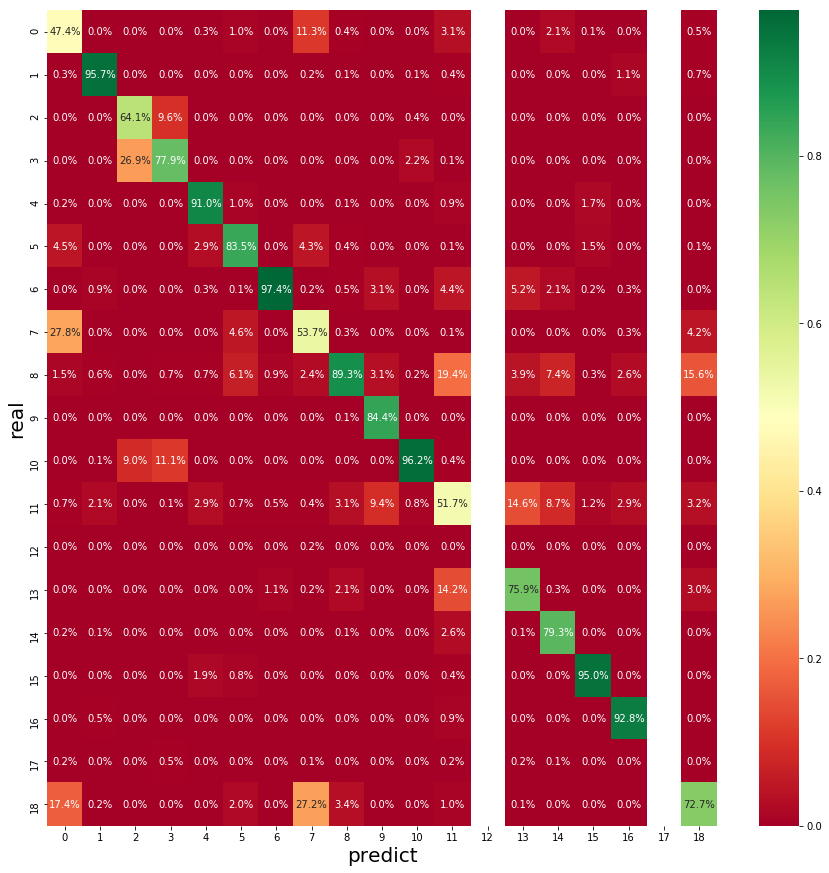

In [52]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

### FINAL CV

In [ ]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
oof_pred = np.zeros((len(train_X), train_y.nunique()))
y_pred = np.zeros((len(test_X), train_y.nunique()))

for fold, (train_ids, val_ids) in enumerate(kf.split(train_X,train_y)):
    print('★ Fold {}'.format(fold + 1))
    X_train, X_val = train_X.iloc[train_ids],train_X.iloc[val_ids]
    y_train, y_val = train_y.iloc[train_ids],train_y.iloc[val_ids]

    eval_set = [(X_train, y_train),(X_val, y_val)]
    eval_names = ['train','val']
    lgbm_c.fit(train_X,train_y, eval_set = eval_set, eval_names = eval_names, 
               early_stopping_rounds= 100, verbose = 100)
    oof_pred[val_ids] = lgbm_c.predict_proba(X_val)
    y_pred += lgbm_c.predict_proba(test_X)/5
loss_score = log_loss(train_y,oof_pred,labels= list(set(train_y)))
print("oof log_loss: ",loss_score)

# REAL

In [ ]:
lgbm_c = lgb.LGBMClassifier(num_leaves = 255, min_child_samples = 40,
                            max_depth = 8, learning_rate = 0.1,
                            lambda_l2 = 3, lambda_l1 = 9,
                            n_estimators=2000, random_state = 42)

In [ ]:
lgbm_c.fit(train_X, train_y, eval_set = [(train_X, train_y)],eval_names= 'valid', 
           eval_metric = 'logloss', verbose = 100, early_stopping_rounds = 100)

In [ ]:
f_train_y_pred = lgbm_c.predict_proba(train_X)

In [ ]:
y_pred = lgbm_c.predict_proba(test_X)

In [ ]:
y_pred

In [ ]:
y_pred

In [ ]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('./submisson/submission.csv', index=True)